# 0. IMPORTS

In [1]:
import os
import warnings
import numpy               as np
import psycopg2            as pg
import pandas              as pd
import matplotlib.pyplot   as plt
import seaborn             as sns

import sweetviz            as sv
import matplotlib.patches  as mpatches

from sklearn               import model_selection as ms
from dotenv                import load_dotenv
from IPython.display       import HTML
from IPython.display       import display

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    # Optimize general settings, standardize plot sizes, etc
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
   # for pandas to display the complete dataframe, with no restriction on the number of columns to be displayed, I can change the following option:
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)

    
def psycopg_connect():
    """ Database connection: Creates a psycopg connection from file .env """
    load_dotenv()
    conn = pg.connect( user = os.environ['DBUSER'],
                       password = os.environ['PASSWORD'],
                       host = os.environ['HOST'],
                       port = os.environ['PORT'],
                       database = os.environ['DBNAME'])
    
    """ create a cursor object used to perform queries """
    cursor = conn.cursor()
    
    return conn, cursor

In [3]:
jupyter_settings()
warnings.filterwarnings("ignore")

# 1.0. DATA COLLECTION

## 1.1. Schema 

In [4]:
conn, cursor = psycopg_connect()

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

cursor.execute(query_schema)

record = cursor.fetchall()
print(record)
cursor.close()
conn.close()

[('pg_toast',), ('pg_temp_1',), ('pg_toast_temp_1',), ('pg_catalog',), ('information_schema',), ('public',), ('pa004',), ('pg_temp_4',), ('pg_toast_temp_4',), ('pa005',), ('pg_temp_9',), ('pg_toast_temp_9',)]


## 1.2. Selecting Tables from Schema

In [5]:
conn, cursor = psycopg_connect()

query_tables = """
    SELECT tablename
    FROM pg_catalog.pg_tables
    WHERE schemaname = 'pa004'
"""

cursor.execute(query_tables)

record = cursor.fetchall()
print(record)
cursor.close()
conn.close()

[('users',), ('vehicle',), ('insurance',)]


## 1.3. Table Users 

In [6]:
conn, cursor = psycopg_connect()

query_table_users = """
    SELECT *
    FROM pa004.users u
    LIMIT 10
"""

cursor.execute(query_table_users)

display( pd.read_sql( query_table_users, conn))

cursor.close()
conn.close()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0
5,6,Female,24,33.0,160.0
6,7,Male,23,11.0,152.0
7,8,Female,56,28.0,26.0
8,9,Female,24,3.0,152.0
9,10,Female,32,6.0,152.0


## 1.4. Raw Dataset

In [7]:
conn, cursor = psycopg_connect()

query_table_users = """
    SELECT *
    FROM pa004.users u
    LEFT JOIN pa004.vehicle  v ON v.id = u.id
    LEFT JOIN pa004.insurance i ON i.id = u.id
"""

cursor.execute(query_table_users)

df_raw = pd.read_sql( query_table_users, conn)
display(df_raw.head(10))

cursor.close()
conn.close()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0
5,55,Female,44,28.0,13.0,55,1,1-2 Year,Yes,55,0,45415.0,73,0
6,73,Female,23,39.0,152.0,73,1,< 1 Year,No,73,1,40372.0,242,0
7,79,Male,29,28.0,26.0,79,1,1-2 Year,Yes,79,0,42567.0,167,1
8,95,Female,23,15.0,152.0,95,1,< 1 Year,Yes,95,0,41641.0,209,0
9,108,Male,31,29.0,124.0,108,1,1-2 Year,Yes,108,0,28867.0,247,0


In [8]:
df_raw.to_csv('/home/rafael/Repos/cross_sell_prediction/data/data_collection_done.csv')

# 2.0. DATA DESCRIPTION

In [9]:
df2 = pd.read_csv('/home/rafael/Repos/cross_sell_prediction/data/data_collection_done.csv', index_col=0)
df2.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'id.1',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'id.2',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 2.1. Dropping Columns 

In [10]:
# Dropping Columns "ID" 
df2 = df2.drop( df2.columns [[5,9]], axis =1 )
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 2.2. Data Dimensions


In [11]:
print('Number of rows: {}'. format(df2.shape[0]))
print('Number of columns: {}'.format(df2.shape[1]))

Number of rows: 381109
Number of columns: 12


## 2.3. Data Types

In [12]:
df2.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 2.4. Check NA

In [13]:
df2.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 2.5 Descriptive Statistical Analysis

Descriptive statistics summarizes or describes the characteristics of a data set. 

In [14]:
num_attributes = df2.select_dtypes( include = ('int64','float64'))
cat_attributes = df2.select_dtypes( exclude = ('int64','float64','datetime64[ns]'))
num_attributes.sample(2)

,id,age,region_code,policy_sales_channel,driving_license,previously_insured,annual_premium,vintage,response
56725,71816,38,8.0,152.0,1,1,37722.0,206,0
119633,193166,48,29.0,124.0,1,0,38107.0,163,1


### 2.5.1. Numerical Attributes

In [15]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate
n = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
n.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [16]:
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


## 2.6. Train Test Split

In [17]:
# Test Dataset Extraction
X = df2.drop('response', axis = 1).copy()
y = df2['response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 45)

# df2 is the new dataset, and will be used to train and validate the models
df2 = pd.concat([x_train, y_train], axis = 1)

# df_test is a separate dataset, and will be used to perfomr the final evaluation of the trained model
df_test = pd.concat([x_test, y_test], axis = 1)

In [18]:
#Check test stratify
df_test['response'].value_counts() / df_test['response'].count() 

0    0.877437
1    0.122563
Name: response, dtype: float64

In [19]:
#Check train stratify
df2['response'].value_counts() / df2['response'].count()

0    0.877437
1    0.122563
Name: response, dtype: float64

In [20]:
df2.shape

(304887, 12)

In [21]:
df_test.shape

(76222, 12)

In [22]:
#Export Test
df_test.to_csv('/home/rafael/Repos/cross_sell_prediction/data/'+'df_test.csv')

# 3.0. FEATURE ENGINEERING

In [23]:
df3 = df2.copy()

In [24]:
print(df3['vehicle_age'].unique())
print(df3['vehicle_damage'].unique())

# # vehicle_age
# df3['vehicle_age'] = df3['vehicle_age'].apply(lambda x: 'below_1_year' if x == ('< 1 Year') else 'between_1_2_year' if x == ('1-2 Year') else 'over_2_years')

# #vehicle_damage
# df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# vehicle age
dict_vehicle_age = {'> 2 Years':'over_2_years', '1-2 Year':'between_1_2_year', '< 1 Year':'below_1_year'}
df3['vehicle_age'] = df3['vehicle_age'].map(dict_vehicle_age)

# vehicle damage
dict_vehicle_damage = {'Yes': 1, 'No': 0}
df3['vehicle_damage'] = df3['vehicle_damage'].map(dict_vehicle_damage)

df3.head()

['1-2 Year' '< 1 Year' '> 2 Years']
['Yes' 'No']


,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
332417,371361,Female,52,28.0,124.0,1,between_1_2_year,1,0,25037.0,68,0
318002,255092,Male,23,16.0,163.0,1,below_1_year,1,0,28314.0,182,0
192366,12237,Male,34,28.0,26.0,1,between_1_2_year,1,0,24715.0,10,0
126655,248977,Female,46,15.0,14.0,1,between_1_2_year,1,0,40678.0,253,0
318534,259597,Male,50,8.0,124.0,1,between_1_2_year,1,0,38292.0,72,0


# 4.0. DATA FILTERING

The dataset does not present any inconsistent data as showed in the Descriptive Statistical Analysis. In this case, no data will be filtered for now. 

# 5.0. EXPLORATORY DATA ANALYSIS

In [25]:
df5 = df3.copy()

## 5.1. SweetVIZ Dashboard

Looking for features that will separate the clients who are more likely to accept the new offer - cross sell.

This analysis will provide a brief understanding of which variables are relevant to the model.

In [26]:
report = sv.analyze(df5, target_feat='response')
report.show_html(filepath='/home/rafael/Repos/cross_sell_prediction/reports/SWEETVIZ_REPORT.html', open_browser = False)

                                             |      | [  0%]   00:00 -> (? left)

Report /home/rafael/Repos/cross_sell_prediction/reports/SWEETVIZ_REPORT.html was generated.



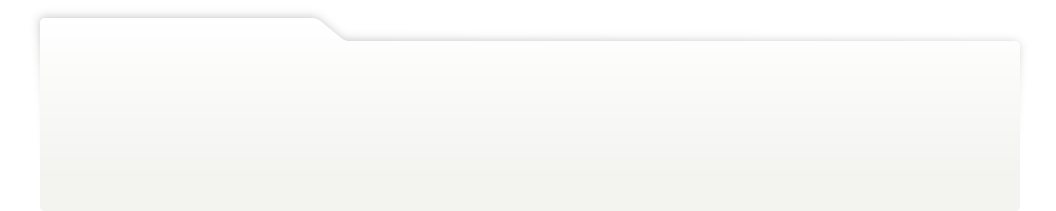
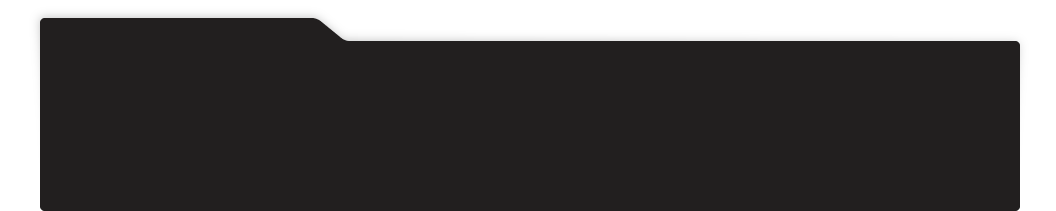
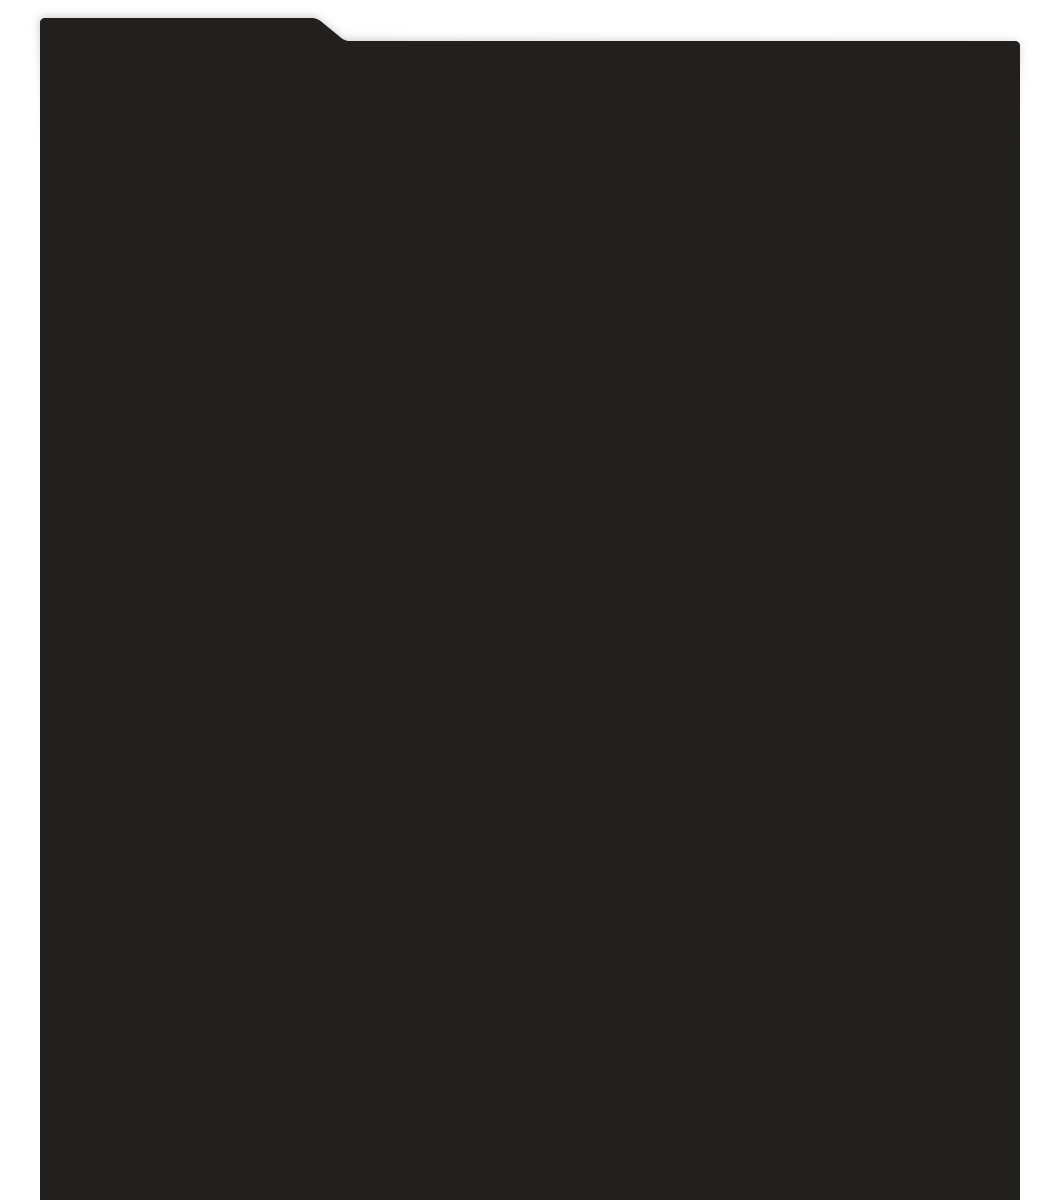
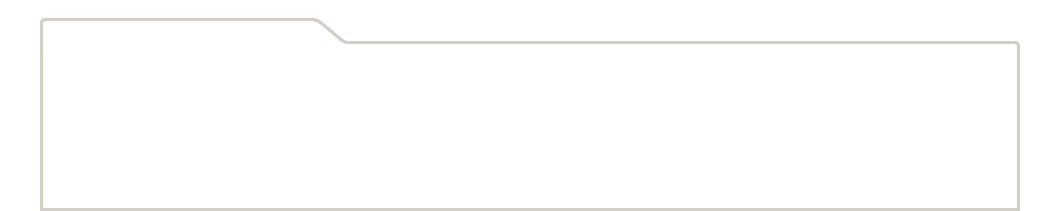
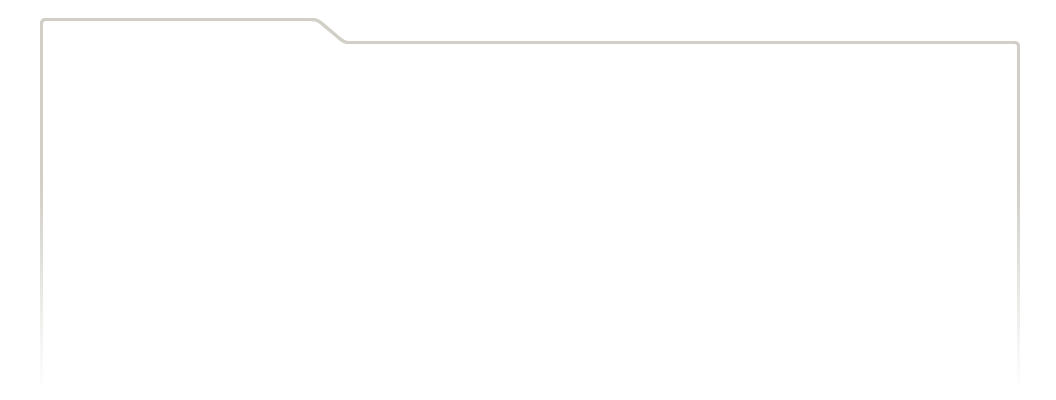
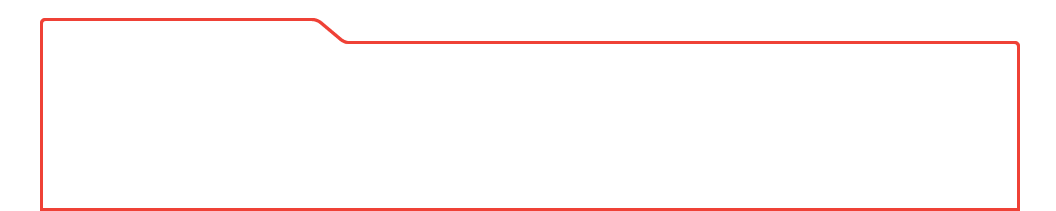
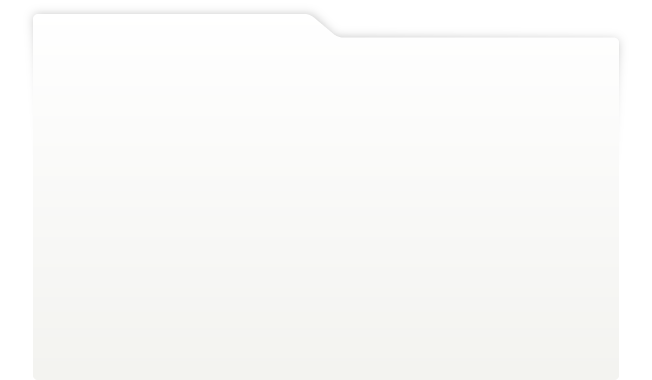
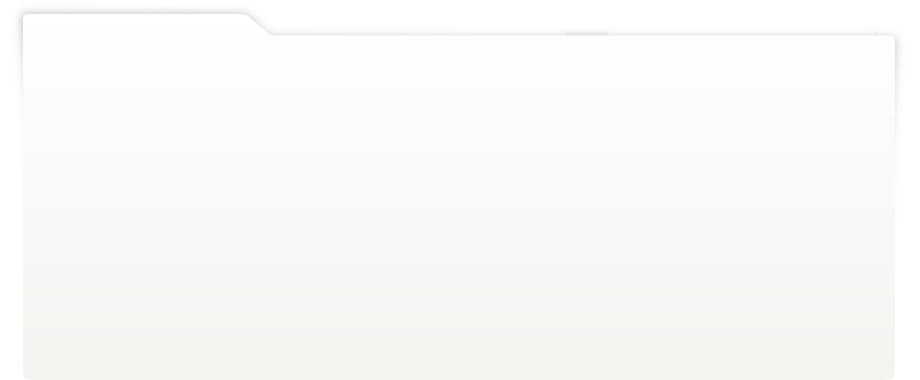
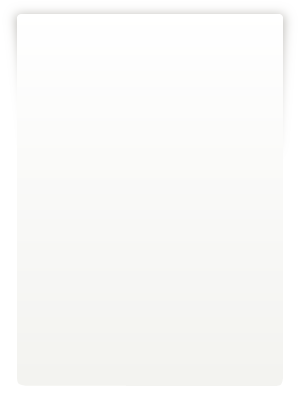
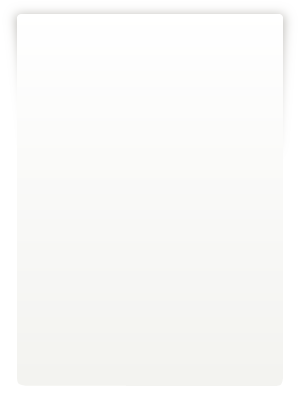
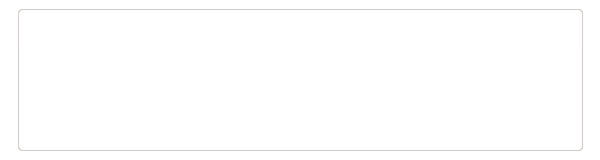
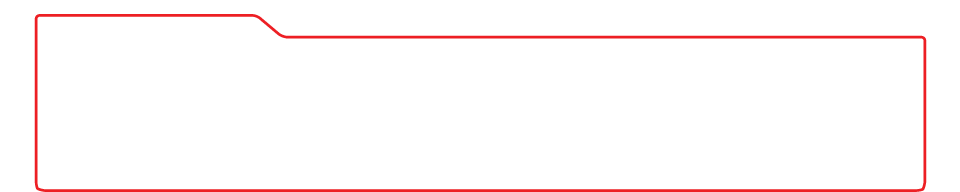
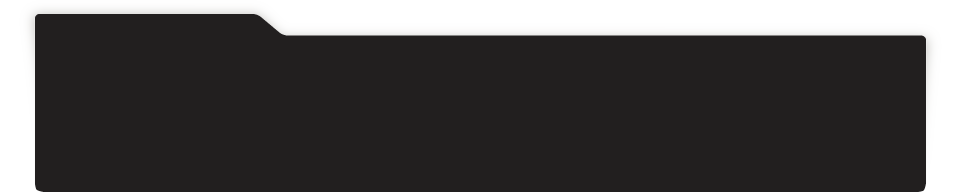
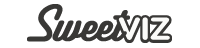
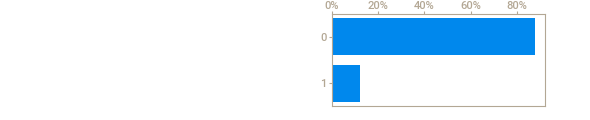
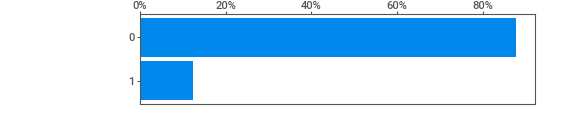
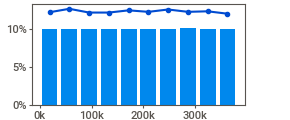
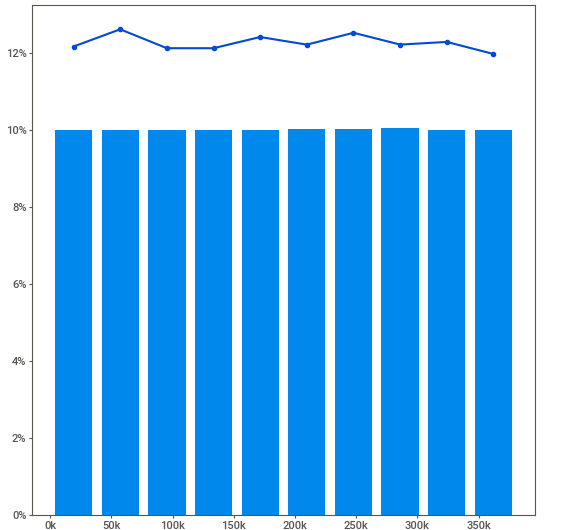
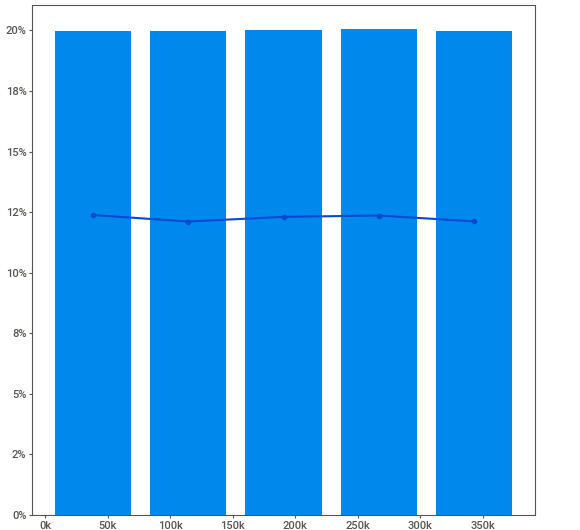
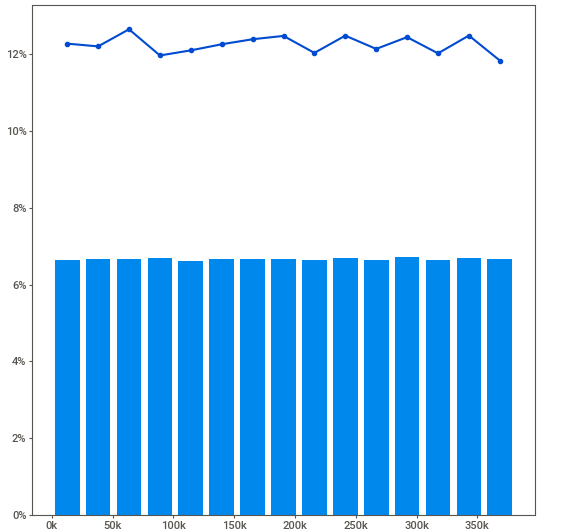
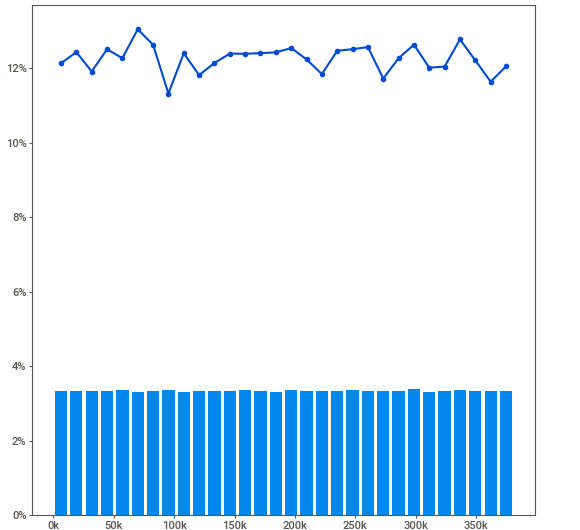
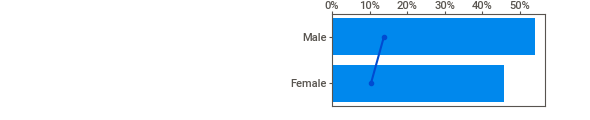
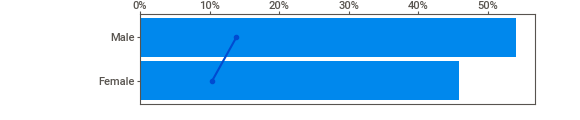
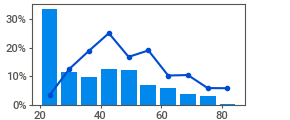
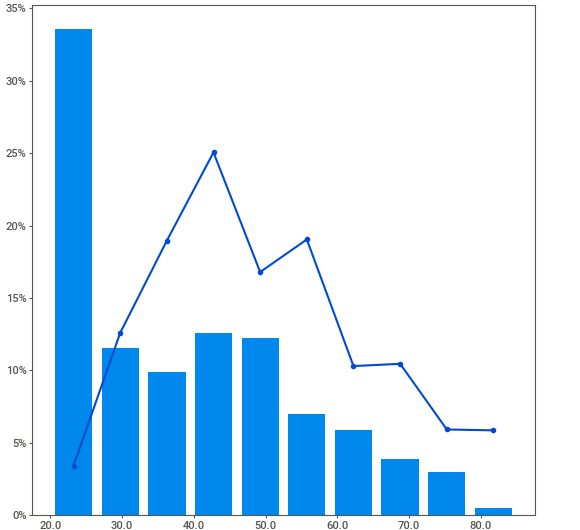
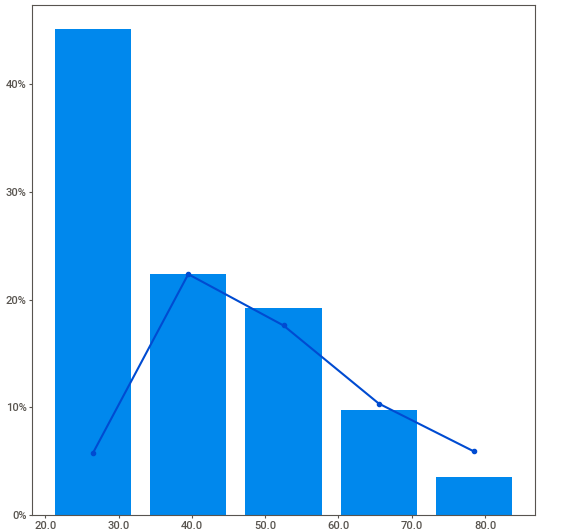
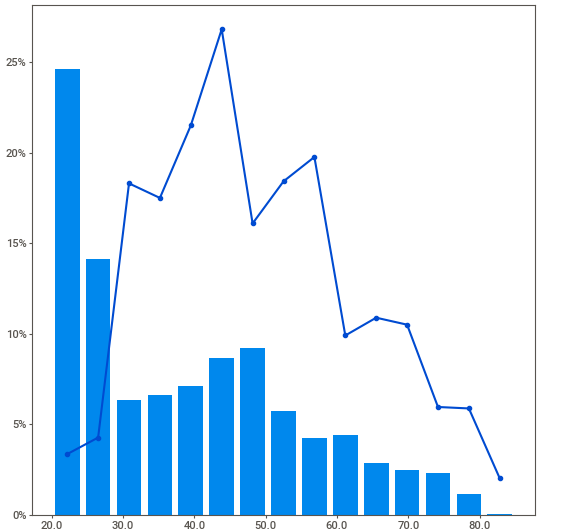
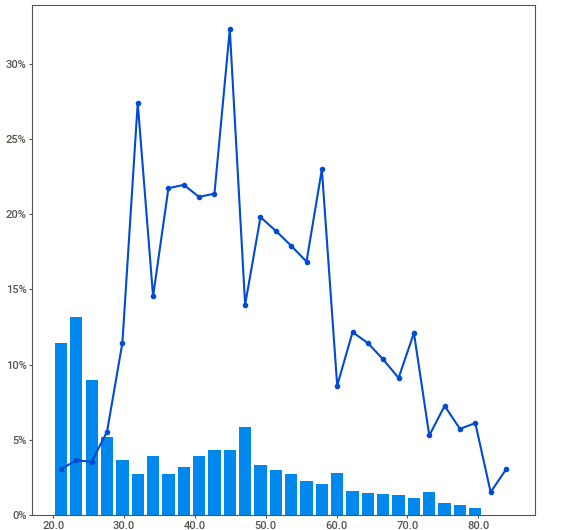
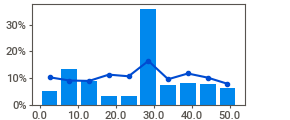
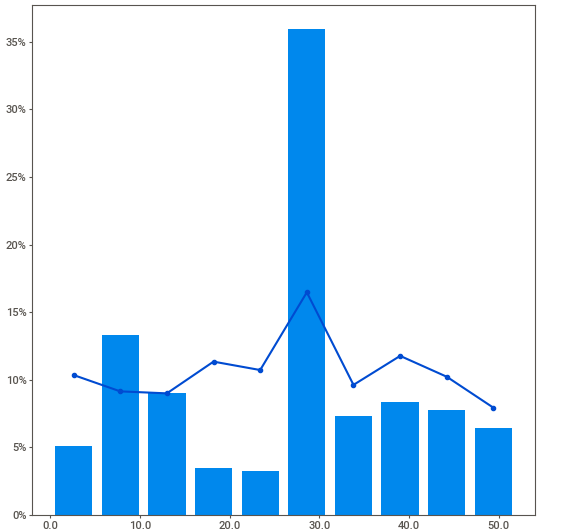
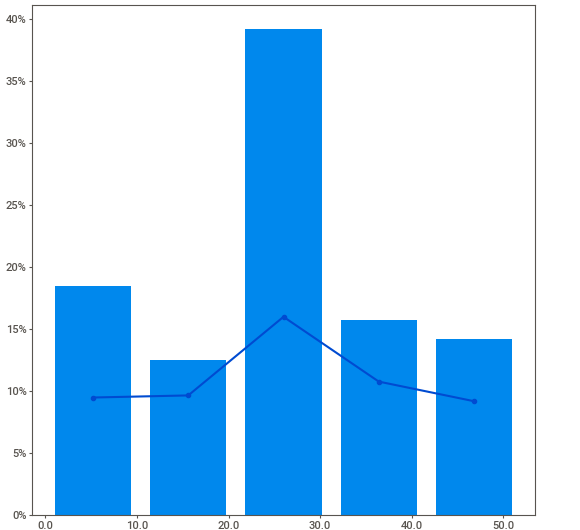
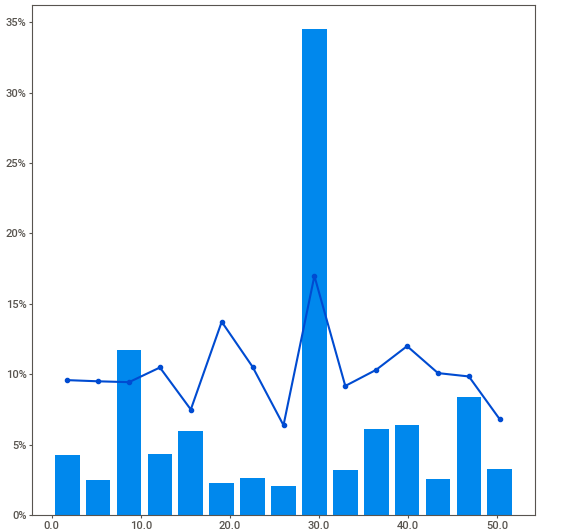
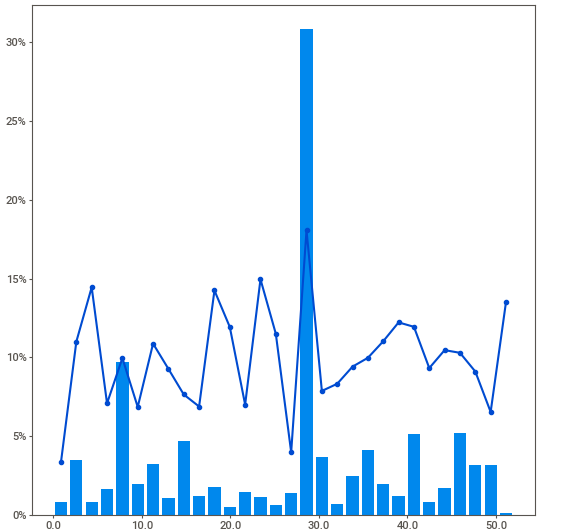
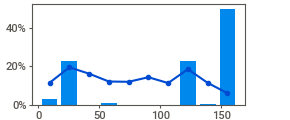
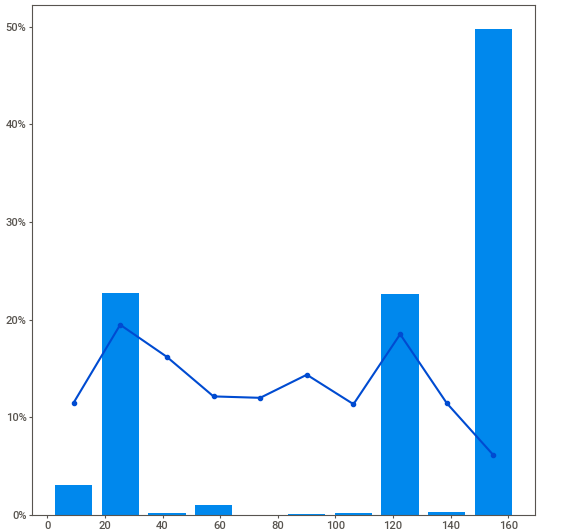
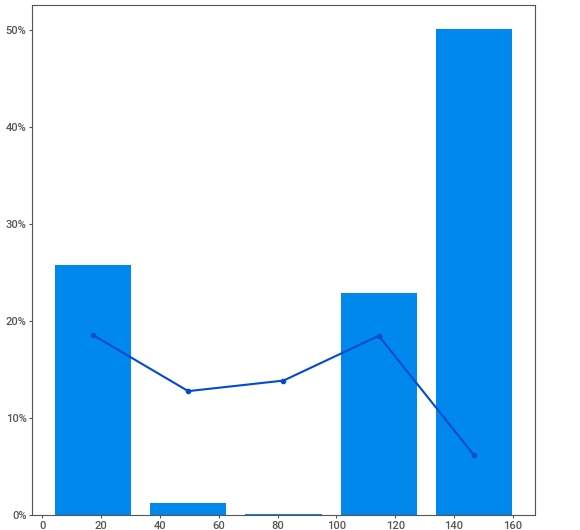
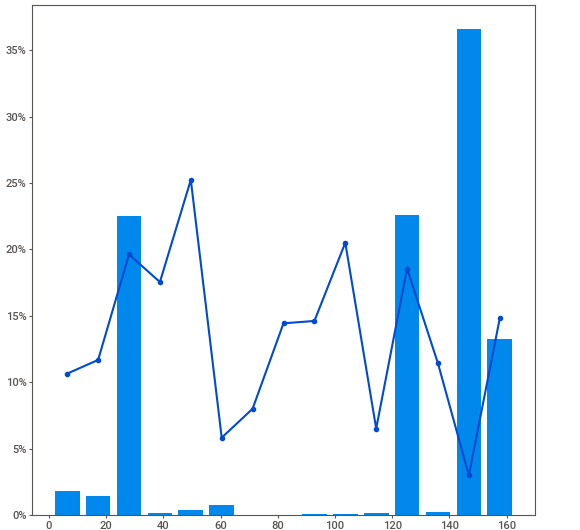
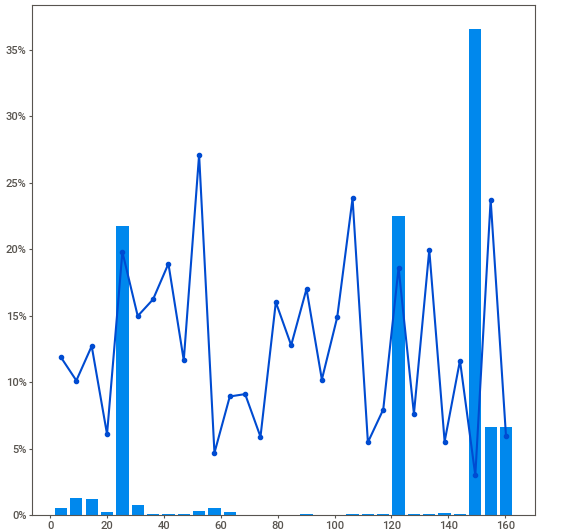
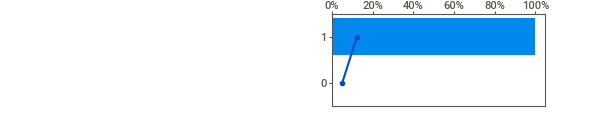
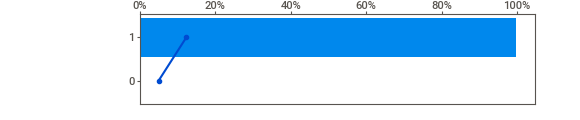
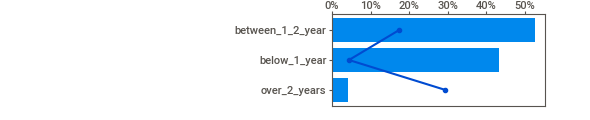
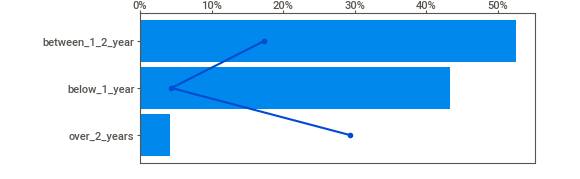
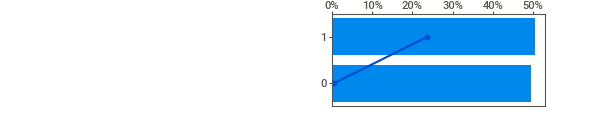
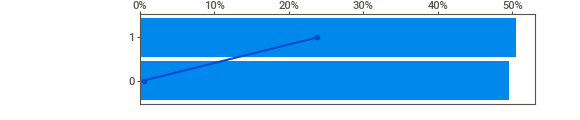
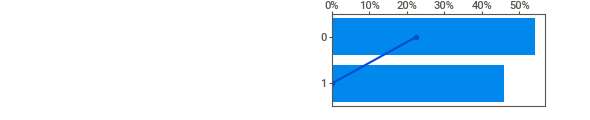
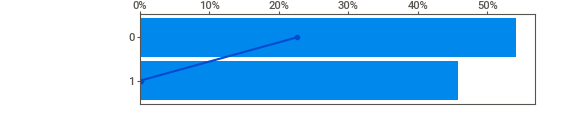
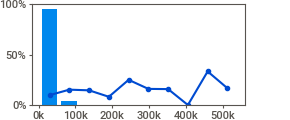
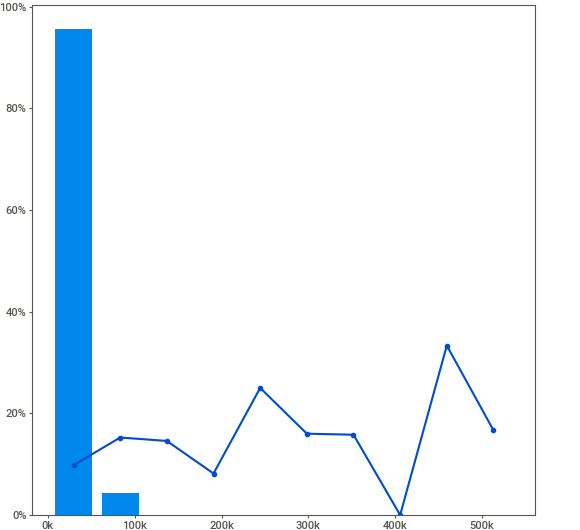
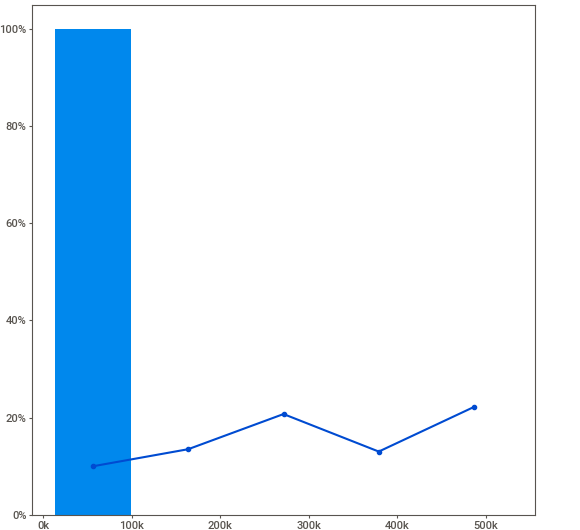
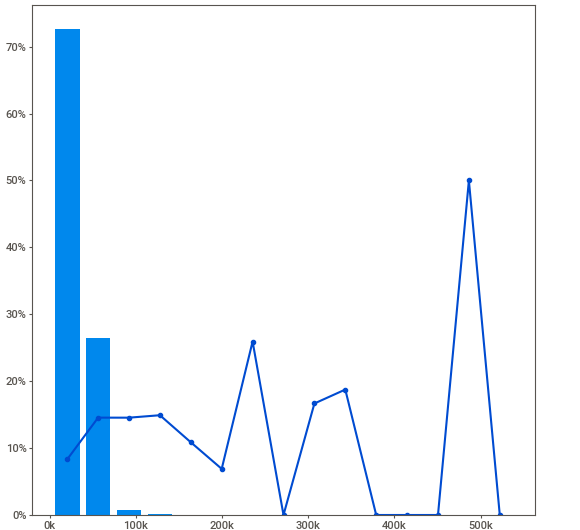
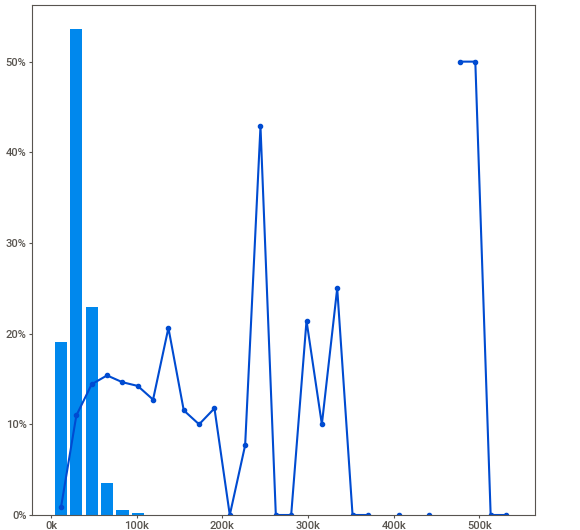
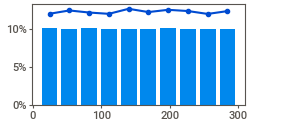
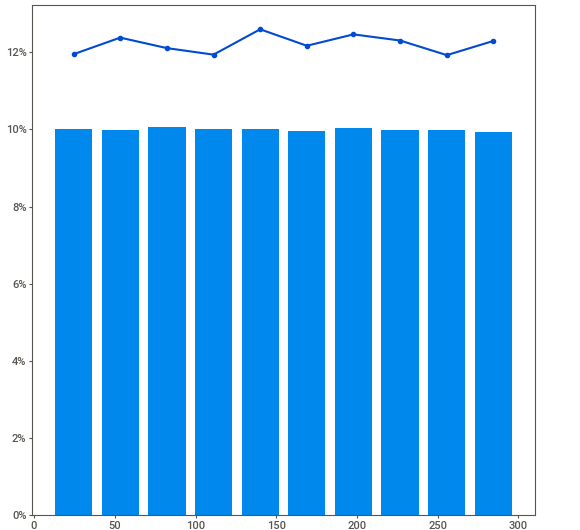
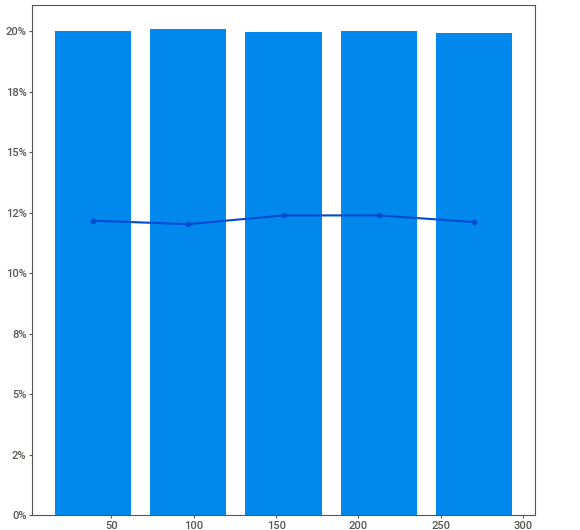
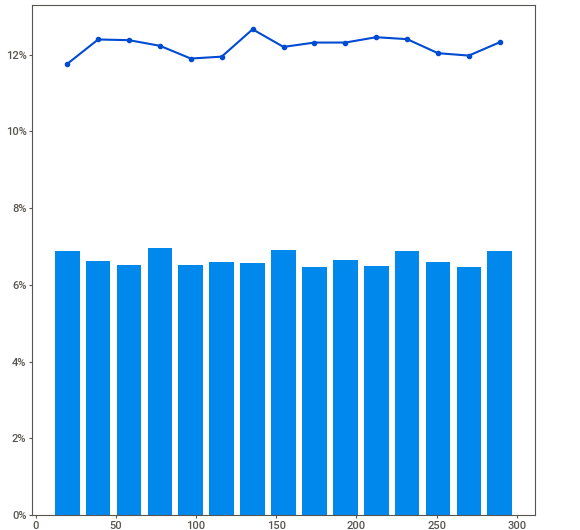
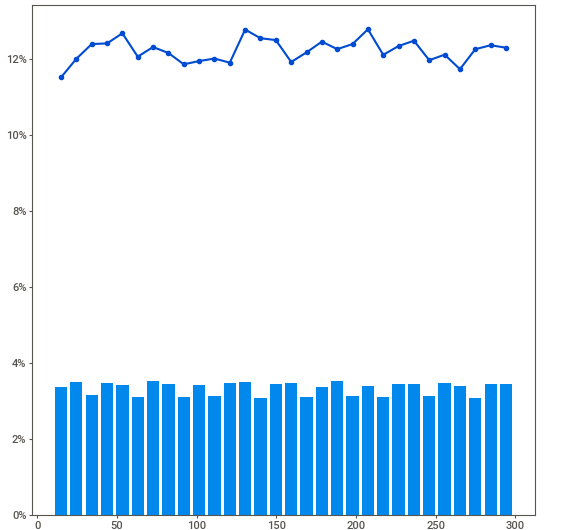
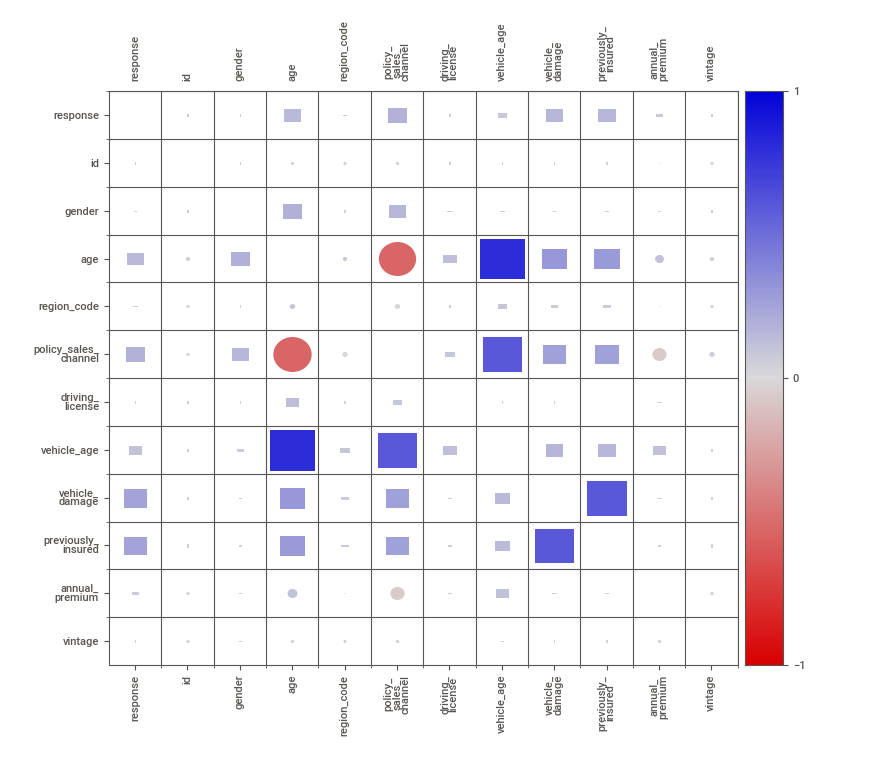
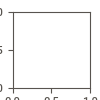

In [27]:
report.show_notebook(w=None, h=None,scale=None,layout='vertical')

## 5.2. Data Summary

### 5.2.1. Variable Response

In [28]:
df5['response'].value_counts(normalize = True)

0    0.877437
1    0.122563
Name: response, dtype: float64

* 12% of customers are interested in purchasing the car insurance, compared to 88% of people not interested (12% vs 88%)

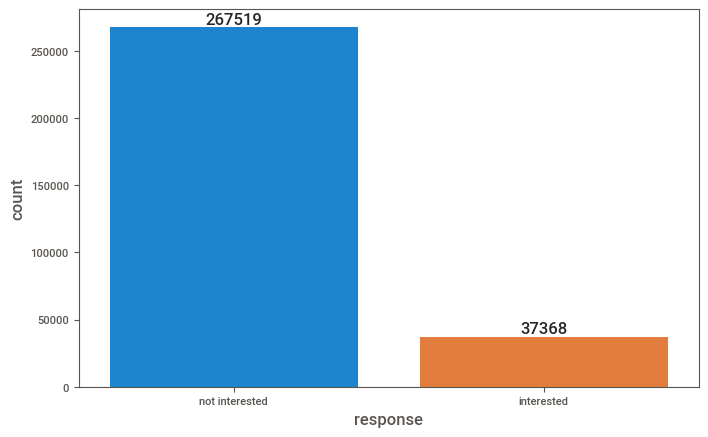

In [29]:
fig = plt.figure(figsize = [8,5])
ax = sns.countplot(x = 'response', data = df5)
ax.set_xticklabels(['not interested', 'interested']);
ax.bar_label(ax.containers[0]);

### 5.2.2. Age

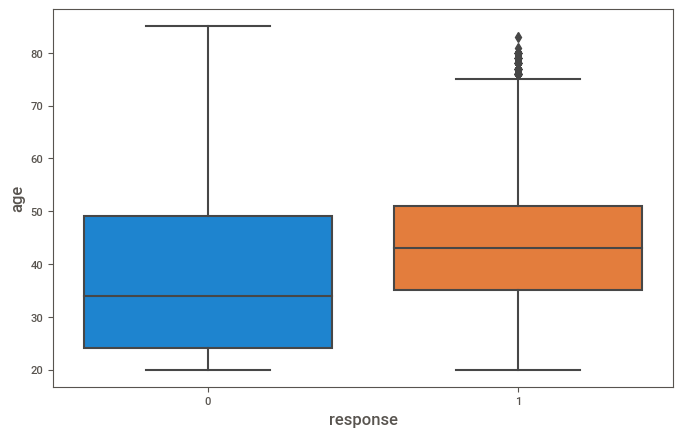

In [30]:
fig = plt.figure(figsize = [8,5])
sns.boxplot(x = df5['response'], y = df5['age'])
plt.show()

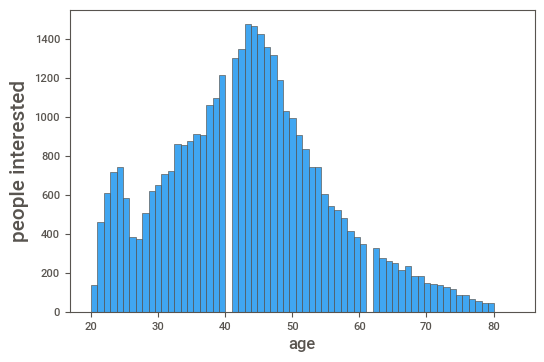

In [31]:
fig = plt.figure(figsize = [6,4])
aux01 = df5.loc[df5['response'] == 1, 'age']
p = sns.histplot( aux01 ) 
p.set_ylabel("people interested", fontsize = 15)
plt.show()

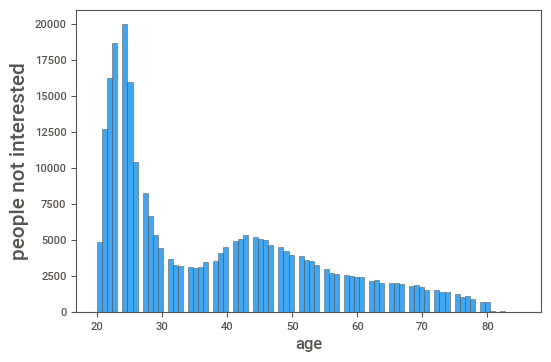

In [32]:
fig = plt.figure(figsize = [6,4])
aux00 = df5.loc[df5['response'] == 0, 'age']
p = sns.histplot( aux00 )
p.set_ylabel("people not interested", fontsize = 15)
plt.show()

People not interested in purchasing the new product: Median - 35 years old, 1st and 3rd quartiles - 24 and 50 years

People interested in purchasing the new product: Median - 42 years old, 1st and 3rd quartiles - 35 and 51 years

Notice the volume of data in the "not interested" group is larger. So we can not get to a conclusion yet. Just an observation.

### 5.2.3. Annual Premium

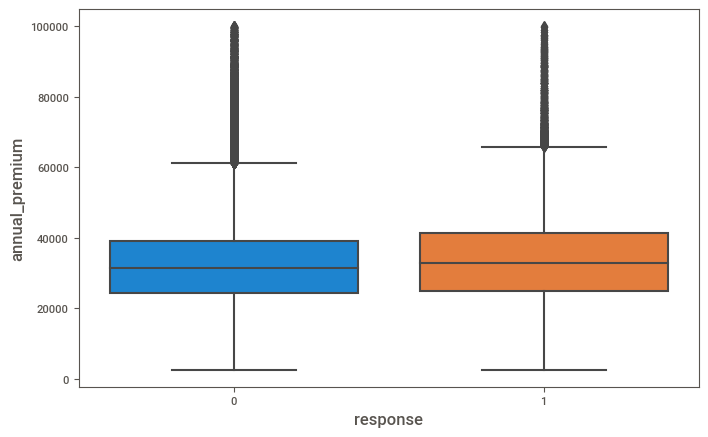

In [33]:
plt.figure(figsize = [8,5])
sns.boxplot(x = 'response', y = 'annual_premium', data = df5[df5['annual_premium'] < 100000])
plt.show()

Not much information can be retrieved from this feature in terms of how interested customers are in purchasing the vehicle insurance.

### 5.2.4. Gender

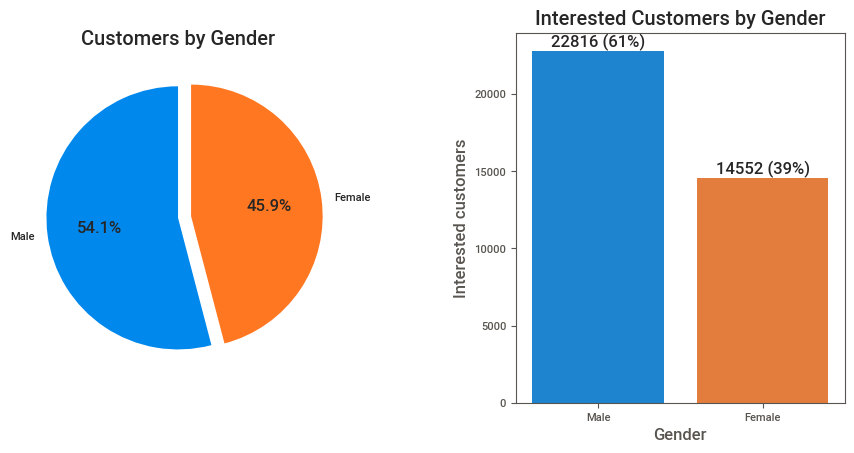

In [34]:
# Gender Interest Dashboard
#percentage of customers per gender
plt.figure(figsize=(10,6))
pie_gen = plt.subplot (1,2,1)

pie_gen.set_title('Customers by Gender')
perc_m, perc_f = df5['gender'].value_counts(normalize = True)
pie_gen.pie([perc_m, perc_f], explode=(0, 0.1), labels=['Male', 'Female'], autopct='%1.1f%%', startangle=90);

#interested customers per gender
bar_gen = plt.subplot (1,2,2)

# labels
gen_true = df5.loc[df5['response'] == 1]
gen_res = sns.countplot(x=gen_true['gender']);
abs_values = gen_true['gender'].value_counts(ascending=False)    
rel_values = gen_true['gender'].value_counts(ascending=False, normalize=True).values *100

lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
gen_res.bar_label(container=gen_res.containers[0], labels=lbls);

bar_gen.set_title('Interested Customers by Gender')
bar_gen.set_xlabel('Gender')
bar_gen.set_ylabel('Interested customers')
plt.tight_layout(pad=5)

* 54% of customers are male, and 61% of interested customers in the car insurance are male

Meaning that in general, men are more likely to be interested in the car insurance 

### 5.2.5. Region Code

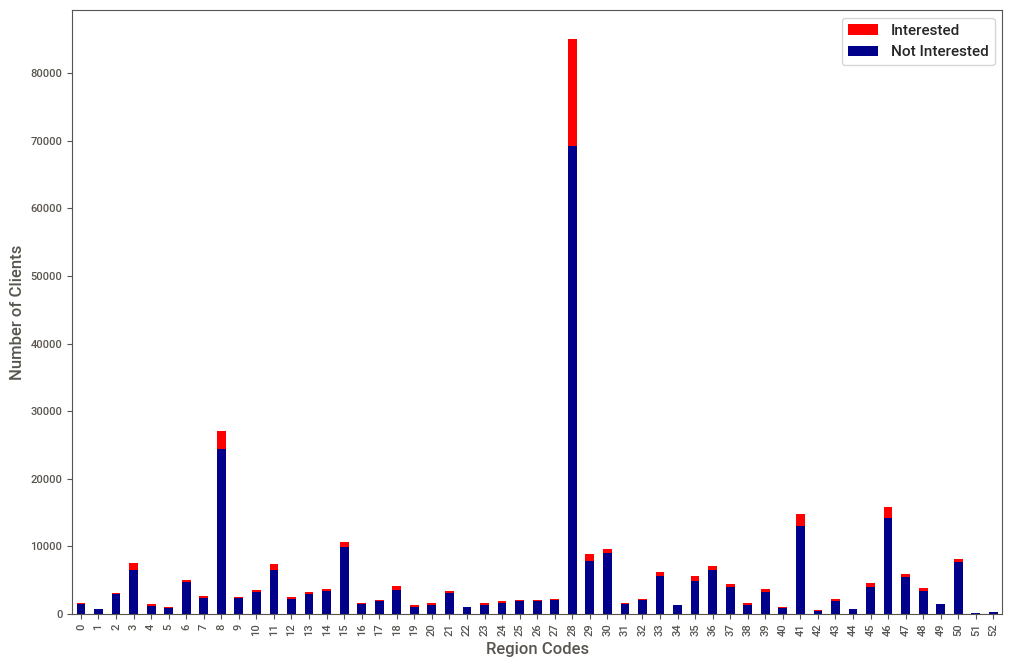

In [35]:
aux = df5[['response','region_code']]
aux1 = aux[aux['response'] == 1].groupby('region_code').count().reset_index()
aux2 = aux[aux['response'] == 0].groupby('region_code').count().reset_index()

result = aux2.merge(aux1, how='inner', on='region_code')

result.plot(kind='bar', stacked=True, color=['red', 'darkblue'], legend = False);
plt.legend(["Interested", "Not Interested"]);


# labels for x & y axis
plt.xlabel('Region Codes');
plt.ylabel('Number of Clients');




 * Region 28 contains most part of the customers and also most percentage of people interested in the car insurance



### 5.2.6. Previously Insured

In [36]:
pd.crosstab( df5['previously_insured'], df5['response'] ).apply( lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774497,0.225503
1,0.999113,0.000887


In [37]:
#0.1% of customers who had vehicle previously insured are interested in vehicle insurance.
df_insured = df5.loc[df5['previously_insured'] == 1]
df_insured['response'].value_counts() / df_insured['response'].shape[0] *100

0    99.911256
1     0.088744
Name: response, dtype: float64

* 22% of customers who didn't have vehicle previously insured are interested in vehicle insurance

### 5.2.7. Vehicle Age

In [38]:
pd.crosstab( df5['vehicle_age'], df5['response'] ).apply( lambda x: x / x.sum(), axis=1)

response,0,1
vehicle_age,,
below_1_year,0.955995,0.044005
between_1_2_year,0.826384,0.173616
over_2_years,0.706895,0.293105


The interest in the vehicle insurance is greater in customers with older vehicle age:

   * 29% of customers with vehicles over 2 years are interested.
   * 17% of customers with vehicles between 1 and 2 years are interested.
   * 4% of customers with vehicles below 1 year are interested.



### 5.2.8. Policy Sales Channel

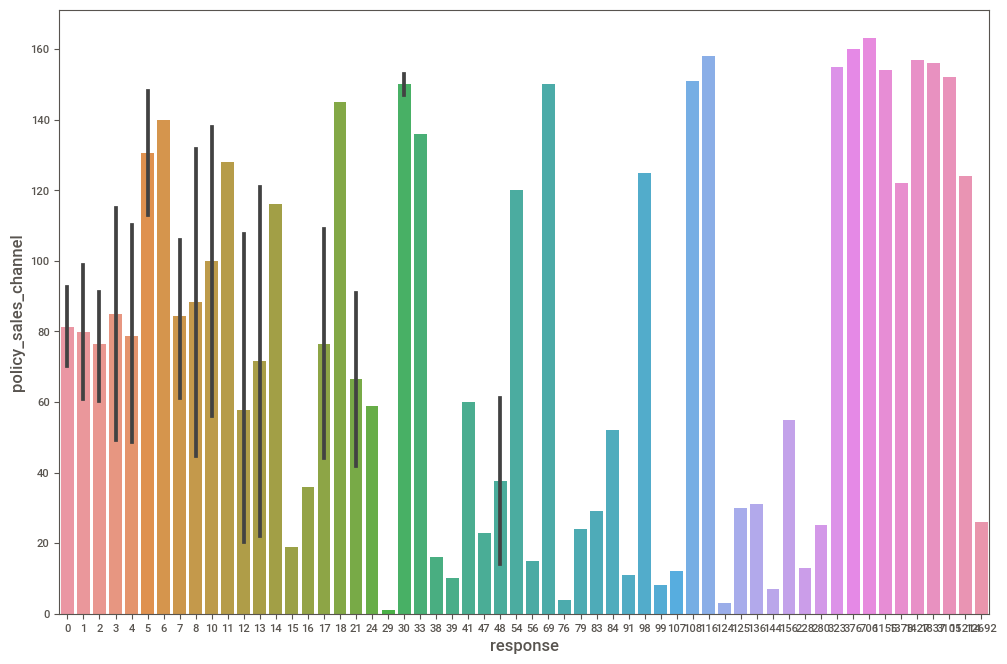

In [39]:
aux = df5[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux);

### 5.2.9. Vehicle Damage

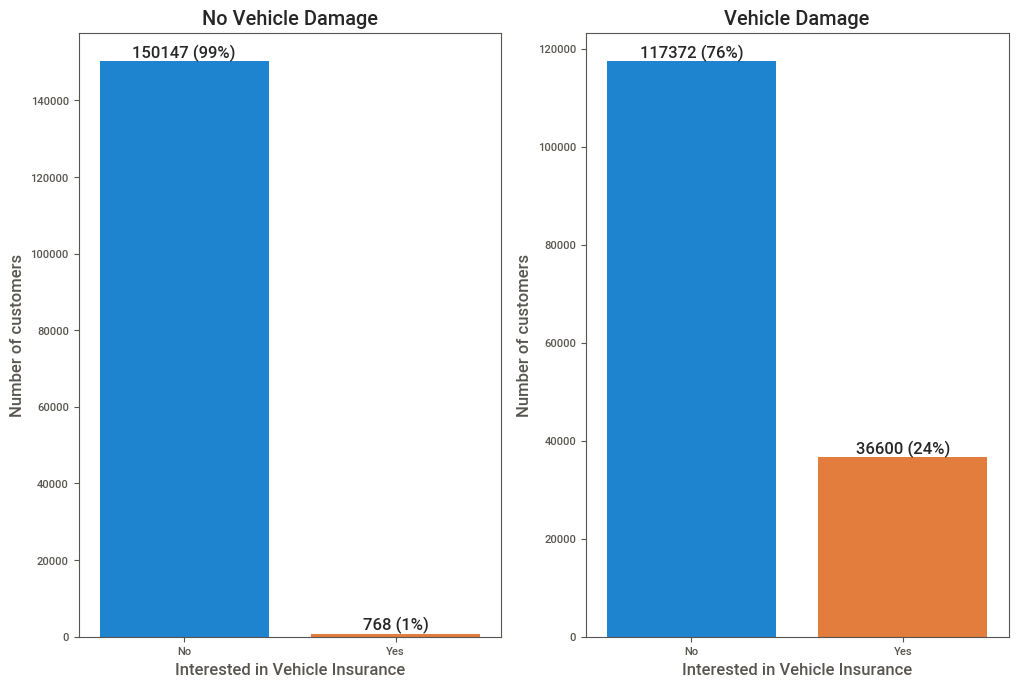

In [40]:
#vehicle_damage == 0(no): interested / not interested
plt.subplot (1,2,1)
aux00 = df5.loc[df5['vehicle_damage'] == 0]
aux01 = aux00[['vehicle_damage', 'response']].groupby('response').count().reset_index()
fig_not_damaged = sns.barplot (x = 'response', y='vehicle_damage', data=aux01);

abs_values0 = aux00['response'].value_counts(ascending=False)    
rel_values0 = aux00['response'].value_counts(ascending=False, normalize=True).values *100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values0, rel_values0)]
fig_not_damaged.bar_label(container=fig_not_damaged.containers[0], labels=lbls);

fig_not_damaged.set_xlabel('Interested in Vehicle Insurance')
fig_not_damaged.set_ylabel('Number of customers')
fig_not_damaged.set_title('No Vehicle Damage');
fig_not_damaged.set_xticklabels(['No', 'Yes']);


#vehicle_damage == 1(yes): interested / not interested
plt.subplot (1,2,2)
aux10 = df5.loc[df3['vehicle_damage'] == 1]
aux11 = aux10[['vehicle_damage', 'response']].groupby('response').count().reset_index()
fig_damaged = sns.barplot(x = 'response', y='vehicle_damage', data=aux11);

abs_values1 = aux10['response'].value_counts(ascending=False)    
rel_values1 = aux10['response'].value_counts(ascending=False, normalize=True).values *100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values1, rel_values1)]
fig_damaged.bar_label(container=fig_damaged.containers[0], labels=lbls);

fig_damaged.set_xlabel('Interested in Vehicle Insurance')
fig_damaged.set_ylabel('Number of customers')
fig_damaged.set_title('Vehicle Damage');
fig_damaged.set_xticklabels(['No', 'Yes']);


* 24% of customers how had vehicle damage are interested in vehicle insurance, while only 1% of those who didn't have vehicle damage are interestet.

### 5.2.10. Vintage

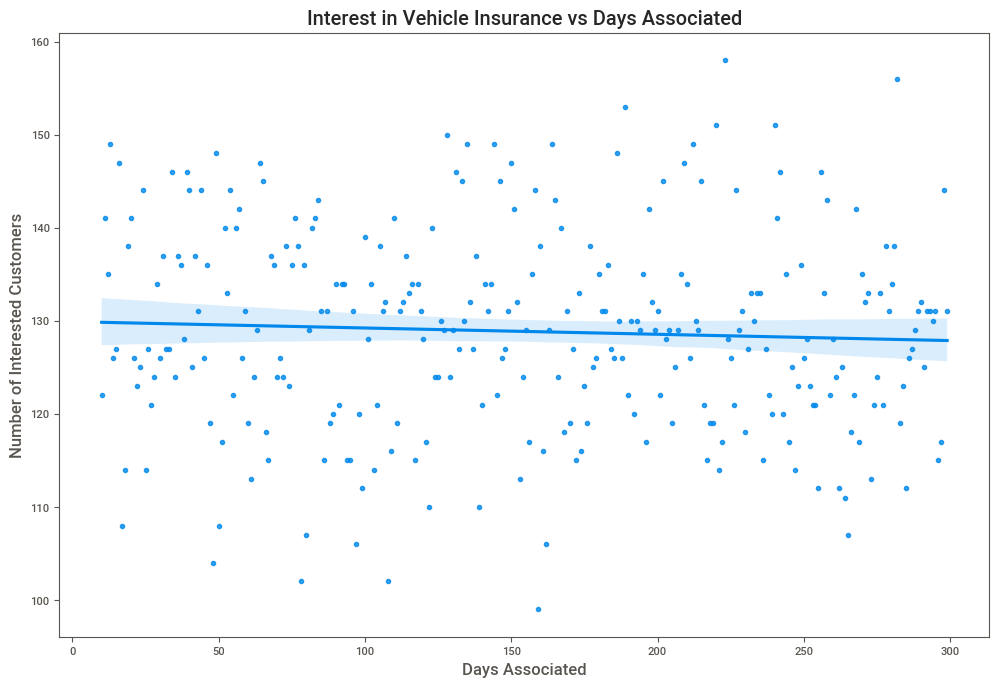

In [41]:
# get just the interested customers
aux = df5[['vintage', 'response']].groupby('vintage').sum().reset_index()
vint = sns.regplot (x= 'vintage', y='response', data=aux)
vint.set_xlabel('Days Associated');
vint.set_ylabel('Number of Interested Customers')
vint.set_title('Interest in Vehicle Insurance vs Days Associated');

* There is no significant difference between customers with more days of health insurance (more days associated) and customers who became clients recently in terms of vehicle insurance interest.

## 5.3. Save dataset

In [42]:
#Export Train data
df5.to_csv('/home/rafael/Repos/cross_sell_prediction/data/'+'eda_complete.csv') # eda complete